# Analytics of pro cycling

### INTRO:
I have always been fascinated with pro cycling and I am a big fan of the major cycling events in Europe and in the rest of the world, such as the tour de France, ronde van Vlaanderen, Paris-Roubaix etc.           
Therefore, I wanted to know more about cycling and take a look into the data to make some kind of analysis. However, one problem is that there is nearly no data available on popular sites such as Kaggle or even the Google dataset search engine. Since there is no public and structured data available, I have to take a look at public and unstructured data and thankfully there is plenty of that.   
I eventually found a site called procyclingstats.com. It is mainly used to record the results of all noteworthy races. This way, they also give points to each rider's performance within a race based on certain weights and the importance or level of a race. Furthermore, they can create a ranking of those riders to objectively decide which riders perform better than others.
For the purpose of my analysis I decide to web scrape this website and hopefully get the information I need to get some findings.         
In the next part, this is exactly what I do. First of all, I webscrape the ranking of the riders and within the rider's name of this ranking-list I can extract another hyperlink that brings me to the page with all the results of the rider and more specific details. I do this for every rider, 2210 riders in total.  
https://www.procyclingstats.com
* I also have to mention that I am not the first to scrape this website. You can find multiple projects on the internet. However, none of my work is based on any project in particular. It is my goal to come up with my own code, analysis and hopefully some useful findings. Nevertheless, I want to mention one additional project below.  
https://github.com/classicoman2/procyclingstats-scraping

### Webscraping Pro Cycling Stats:

In [17]:
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
file="pro_cycling.csv"
f = open(file,"w")
variables="rank, rank_change, rider_name, team, nationality, PCS_points, PCS_points_change, UCI_points, one_day_race, GC, TT, Sprint, Climber, age, height, weight, year_wins, all_year_wins, all_year_GT, all_classics, years_active, race_km, race_days\n"
f.write(variables)
page=[0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200]
for x in page:
    print(x) #It takes about 30 minutes for me to run this, so it's useful to see the progress.
    URL= requests.get("https://www.procyclingstats.com/rankings.php?date=2021-11-27&nation=&age=&zage=&page=smallerorequal&team=&offset="+str(x)+"&filter=Filter&p=me&s=individual")
    soup = bs(URL.content)
    ranking=soup.find("table",{"class":"basic"}).tbody.find_all("tr")
    for i in range(len(ranking)):
        rider_tuple=ranking[i].find_all("td")
        rank=int(rider_tuple[0].string)
        rider_name=rider_tuple[3].a.get_text()
        team=rider_tuple[4].a.string
        if team==None: #Some riders don't have a team, so there's an empty cell.
            team=" "
        if team=="Cofidis, Solutions Crédits": #There's one team with a comma, which messes up the csv-file obviously.
            team= "Cofidis Solutions Crédits"
        PCS_points=int(round(float(rider_tuple[5].a.string)))
        connection=rider_tuple[3].a["href"] #Embedded in the rider's name, there's another link that brings me to the page of the rider.
        URL_rpage=requests.get("https://www.procyclingstats.com/"+connection)
        r_soup=bs(URL_rpage.content)
        rider_info=r_soup.find("div",{"class":"rdr-info-cont"})
        if rider_info.b.next_sibling!=" -": #If the rider's age is missing, there is a - sign where python tries to scrape.
            age=int(re.search("\((.*?)\)",rider_info.sup.next_sibling).group(1)) #I use a regular expression to get the age from between the brackets.
        elif rider_info.b.next_sibling==" -":
            age=" "
        nationality=rider_info.a.string
        try:
            weight=int(round(float(re.search("(.*?)kg",rider_info.find_all("span")[1].b.next_sibling).group(1))))
        except: # If there is no weight,then the span-tag just isn't there, so then the second span-tag is actually the third.
                # This span-tag doesn't have any children, so this throws a NoneType error.
            weight=" "
        try:
            height=float(re.search("(.*?)m",rider_info.find_all("span")[2].b.next_sibling).group(1))
        except: # Same concept as with weight.
            height=" "
        one_day_race=int(rider_info.find("div",{"class":"mt10 pps"}).find_all("li")[0].find("div",{"class":"pnt"}).string)
        GC=int(rider_info.find("div",{"class":"mt10 pps"}).find_all("li")[1].find("div",{"class":"pnt"}).string)
        TT=int(rider_info.find("div",{"class":"mt10 pps"}).find_all("li")[2].find("div",{"class":"pnt"}).string)
        Sprint=int(rider_info.find("div",{"class":"mt10 pps"}).find_all("li")[3].find("div",{"class":"pnt"}).string)
        Climber=int(rider_info.find("div",{"class":"mt10 pps"}).find_all("li")[4].find("div",{"class":"pnt"}).string)
        rider_results=r_soup.find("table",{"class":"rdrResults"})
        year_wins=0
        for i in range(len(rider_results.tbody.find_all("tr"))): #2021 wins isn't available, so I check how many times the rider finished first this year (looping through the results).
            if rider_results.tbody.find_all("tr")[i].find_all("td")[1].string =="1" and len(rider_results.tbody.find_all("tr")[i].find_all("td")[0])!=0: #I exclude GC-wins
                year_wins= year_wins+1
        race_km=int(re.search("(.*?)km",r_soup.find("div",{"class":"rdrResultsSum"}).div.get_text()).group(1))
        race_days=int(r_soup.find("div",{"class":"rdrResultsSum"}).div.b.string)
        all_time_stats=r_soup.find("div",{"class":"right w25 mb_w100"})
        all_year_wins=int(all_time_stats.div.ul.find_all("li")[0].div.string)
        all_year_GT=int(all_time_stats.div.ul.find_all("li")[1].div.string)
        all_classics=int(all_time_stats.div.ul.find_all("li")[2].div.string)
        if len(all_time_stats.tbody.find_all("tr"))>1:
            PCS_points_change=int(round(float(all_time_stats.tbody.find_all("tr")[0].find("td",{"class":"bar"}).div.span.string)-int(all_time_stats.tbody.find_all("tr")[1].find("td",{"class":"bar"}).div.span.string)))
        elif len(all_time_stats.tbody.find_all("tr"))==1: #If it's one, it means that it's the rider's first year.
            PCS_points_change=int(round(float(all_time_stats.tbody.find_all("tr")[0].find("td",{"class":"bar"}).div.span.string)))
        years_active= int(all_time_stats.tbody.find_all("tr")[0].find("td",{"class":"season"}).string)-int(all_time_stats.tbody.find_all("tr")[len(all_time_stats.tbody.find_all("tr"))-1].find("td",{"class":"season"}).string)+1
        if len(rider_tuple[1])!=0:
            rank_change= int(rider_tuple[1].string)-rank
        elif years_active==1:
            rank_change=0 #If it's the rider's first year, the rank_change is 0
        elif len(rider_tuple[1])==0: #There are also riders that don't show a previous rank, but years_active>1
            rank_change=int(all_time_stats.tbody.find_all("tr")[1].find_all("td")[2].string)-rank
        UCI_points=0 # I, again, loop through the rider's results and take the sum of the UCI-points.
        for i in range(len(rider_results.tbody.find_all("tr"))):
            if len(rider_results.tbody.find_all("tr")[i].find_all("td")[7])!=0:
                UCI_points= UCI_points+int(round(float(rider_results.tbody.find_all("tr")[i].find_all("td")[7].string)))
        try:
            if len(r_soup.find("div",{"class":"right w25 mb_w100 mb_mt10"}).find_all("li"))==0:
                contract_until=" " #Some riders have a missing table, since they don't have a contract/team.
            elif len(r_soup.find("div",{"class":"right w25 mb_w100 mb_mt10"}).li.find("div",{"class":"season"}))==1:
                contract_until=int(r_soup.find("div",{"class":"right w25 mb_w100 mb_mt10"}).li.find("div",{"class":"season"}).string)
            elif len(r_soup.find("div",{"class":"right w25 mb_w100 mb_mt10"}).li.find("div",{"class":"season"}))==0:
                contract_until=int(r_soup.find("div",{"class":"right w25 mb_w100 mb_mt10"}).find_all("li",{"class":"main"})[1].find("div",{"class":"season"}).string)
        except: #There also is 1 suspended rider that has some text "suspended rider" where the table should be.
            contract_until=" "
        f.write(str(rank)+", "+str(rank_change)+", "+rider_name+", "+team+", "+nationality+", "+str(PCS_points)+", "+str(PCS_points_change)+", "+str(UCI_points)+", "+str(one_day_race)+", "+str(GC)+", "+str(TT)+", "+str(Sprint)+", "+str(Climber)+", "+str(age)+", "+str(height)+", "+str(weight)+", "+str(year_wins)+", "+str(all_year_wins)+", "+str(all_year_GT)+", "+str(all_classics)+", "+str(years_active)+", "+str(race_km)+", "+str(race_days)+"\n")
f.close()
        

After some coding and trouble-shooting, I eventually manage to transform the procycling data in a csv-file.   
    
Below, I will give a brief description of each variable.  
* rank: The rank of a rider based on his PCS points.
* rank_change: The change in his rank compared to last year's rank.
* rider_name: Last name + first name of the rider.
* team: Current team of the rider.
* nationality: The country of citizenship of the rider.
* PCS_points: 2021 points awarded to a rider by the site based on his achievements and performance.
* PCS_points_change: Difference between the 2021 and 2020 points.
* UCI_points: Points awarded by the Union Cycliste International.(or UCI) This is more acknowledged, however less useful since it doesn't provide us with a database.
* One_day_race: All-time points gotten from one day races. (monuments or races such as Strade Bianche etc.)
* GC: All-time points gotten from participating in a grand tour such as the Tour De France or la Vuelta. Here they don't get points for individual race wins, but they get points for the end-result.
* TT: All-time points gotten from time trials.
* Sprint: All-time points gotten from races that are flat or semi-flat.
* Climber: All-time points gotten from races that are hilly or mountainous.
* Age: The current age of the rider.
* Height: Height of the rider.
* Weight: Weight of the rider.
* year_wins: The number of times a rider finished first during the last year.
* all_year_wins: The number of times a rider finished first during his career.
* all_year_GT: The number of times a rider competed in the Tour, the Giro or the Vuelta.
* all_classics: The number of times a rider competed in one of the five classics.
* years_active: The number of years the rider's results have been recorded for.
* race_km: The number of race kilometers during the last year.
* race_days: The number of days a rider has participated in a race during the last year.
  


<u><b> Objective of the analysis: </b></u>  
First of all, I don't want to limit myself to only one question, since I feel like some of my data might just go to waste if I were to do that.  
  
* First of all, I would like to take a look at the nationality of the riders and create a visualization to see where most cyclists are from and hence in which countries it is considered an important sport.
* Second, I would like to give a look at the BMI, age and experience data of cyclists to see what the ideal 'configuration' is of a rider.
* Lastly, I will create a model to predict the PCS_points (without the UCI points, since the 2 rankings are very much alike and just use some different weights) and see to what extent this is possible.

### Pro cycling in different countries

In [18]:
URL = "pro_cycling.csv"
PCS = pd.read_csv(URL,skipinitialspace=True)
nationality_count=PCS.groupby(["nationality"]).count().reset_index()[["nationality","rank"]]
nationality_count["rider_count"]=nationality_count["rank"]
nationality_count=nationality_count.drop(["rank"],axis=1)
nationality_count["nationality"].to_string()
pop_URL="population_by_country_2020.csv"
pop_data= pd.read_csv(pop_URL,usecols=["Country (or dependency)","Population (2020)"])
pop_data["nationality"] = pop_data["Country (or dependency)"]
pop_data = pop_data.drop("Country (or dependency)",axis=1)
pop_data["nationality"].replace({"Czech Republic (Czechia)":"Czech Republic"}, inplace=True)
pop_data["nationality"].replace({"United Kingdom":"Great Britain"}, inplace=True)
PCS_pop=pd.merge(nationality_count,pop_data,on="nationality")
PCS_pop["pop_per_mil"]= PCS_pop["Population (2020)"]/1000000
PCS_pop["riders_per_million"]= PCS_pop["rider_count"]/PCS_pop["pop_per_mil"]
# top_10 biggest cycling-countries with population over a million.
PCS_pop[PCS_pop["Population (2020)"]>1000000].sort_values("riders_per_million",ascending=False).head(10)

,nationality,rider_count,Population (2020),pop_per_mil,riders_per_million
11,Belgium,175,11598451,11.598451,15.088222
34,Estonia,16,1326693,1.326693,12.060062
29,Denmark,60,5795780,5.795780,10.352360
91,Slovenia,21,2078989,2.078989,10.101064
71,New Zealand,44,4829021,4.829021,9.111578
74,Norway,44,5428594,5.428594,8.105229
70,Netherlands,114,17141544,17.141544,6.650509
62,Mauritius,7,1272140,1.272140,5.502539
27,Cyprus,6,1208886,1.208886,4.963247
96,Switzerland,38,8665615,8.665615,4.385148


You can see that the top 10 mainly consists out of smaller European countries. I will visualize this on a map.

In [19]:
from bokeh.io import output_notebook, show, output_file
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource,LinearColorMapper,HoverTool,ColorBar
from bokeh.palettes import brewer
import json
output_notebook()

Loading BokehJS ...

In [20]:
worldmap=gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))[["name","geometry","continent"]]
worldmap["nationality"]=worldmap["name"]
worldmap=worldmap.drop("name",axis=1)
worldmap["nationality"].replace({"United States of America":"United States","Czechia":"Czech Republic","United Kingdom":"Great Britain"}, inplace=True)
PCS_map= pd.merge(worldmap,PCS_pop,on="nationality")
best_rider=pd.DataFrame(columns=["rider_name","nationality"])
GB_PCS=PCS.groupby("nationality")
for i in range(93):
    b=GB_PCS.get_group(PCS_map["nationality"][i])[GB_PCS.get_group(PCS_map["nationality"][i])["rank"]==GB_PCS.get_group(PCS_map["nationality"][i])["rank"].min()][["rider_name","nationality"]]
    best_rider=best_rider.append(b)
PCS_map=pd.merge(PCS_map,best_rider,on="nationality")
PCS_geojson=GeoJSONDataSource(geojson=PCS_map.to_json())
color= LinearColorMapper(palette = brewer['Spectral'][11], low = 0, high = 10)
legend = ColorBar(color_mapper=color, label_standoff=10,width = 600, height = 25,border_line_color=None,location = (75,0), orientation = 'horizontal')
tooltip = HoverTool(tooltips = [ ("Country","@nationality"),("Total riders","@rider_count"),("Best rider","@rider_name")])
rider_map= figure(title="Popularity of cycling around the world",plot_height=500,plot_width=830,tools=[tooltip])
rider_map.patches(source=PCS_geojson,fill_color={"field":"riders_per_million","transform":color})
rider_map.add_layout(legend,'below')
show(rider_map)

This trend also seems to be the case if we look at it on a map. The fact that Columbia and Ecuador have a slightly different color might have to do with riders like Egan Bernal and Richard Carapaz. The fact that a country like Eritrea is colored bright green might have to do with Biniam Ghirmay getting second at the U23 world championships. Let's now zoom in on Europe. 

In [21]:
EUROPE=PCS_map[PCS_map["continent"]=="Europe"]
EURO_geojson=GeoJSONDataSource(geojson=EUROPE.to_json())
color= LinearColorMapper(palette = brewer['Spectral'][11], low = 0, high = 10)
legend = ColorBar(color_mapper=color, label_standoff=10,width = 600, height = 25,border_line_color=None,location = (0,0), orientation = 'horizontal')
tooltip = HoverTool(tooltips = [ ("Country","@nationality"),("Total riders","@rider_count"),("Best rider","@rider_name")])
rider_map= figure(title="Popularity of cycling in Europe",plot_height=500,plot_width=650,tools=[tooltip],x_range=[-35,60],y_range=[31,84])
rider_map.patches(source=EURO_geojson,fill_color={"field":"riders_per_million","transform":color})
rider_map.add_layout(legend,'below')
show(rider_map)

### Cycling characteristics

First we'll give a look at the BMI of the riders. Is it helpful to have a lower than average BMI or not and how many cyclist are underweight?

<I>Cycling 101</I>: The main reason why cyclists want to keep their weight down is to cycle uphill faster. Cyclist use power-data (watts) to measure the intensity of their efforts. However, when cycling uphill watts/kg becomes the main measure. To optimize this measure cyclists have to weight as little as possible whilst minimizing the loss in power due to their lower body weight. So the reason I look into this question is to see if lighter is always better or if there is a point where the loss in power becomes too big. Ideally, I would analyze power-data, but sadly there is no unified large scale power-data available (at least not publicly).

<u>Summary statistics:</u>

In [22]:
PCS["BMI"]=PCS["weight"]/PCS["height"]**2
points_u=PCS[PCS["BMI"]<18.5]["PCS_points"].mean()
print(f"Avg points underweight = {points_u}")
points_n=PCS[PCS["BMI"]>18.5]["PCS_points"].mean()
print(f"Avg points normal weight = {points_n}")
days_u=PCS[PCS["BMI"]<18.5]["race_days"].mean()
print(f"Avg days underweight = {days_u}")
days_n=PCS[PCS["BMI"]>18.5]["race_days"].mean()
print(f"Avg days normal weight = {days_n}")
win_u=PCS[PCS["BMI"]<18.5]["year_wins"].mean()
print(f"Avg year_wins underweight = {win_u}")
win_n=PCS[PCS["BMI"]>18.5]["year_wins"].mean()
print(f"Avg year_wins normal weight = {win_n}")
#This is also the case if you only look at the 200 highest ranked riders.


Avg points underweight = 149.06060606060606
Avg points normal weight = 143.877151799687
Avg days underweight = 45.06060606060606
Avg days normal weight = 42.75195618153364
Avg year_wins underweight = 0.36363636363636365
Avg year_wins normal weight = 0.568075117370892


Initially we see that underweight riders get a higher PCS score, although we also see that they race 2-3 days more than riders with a healthy weight. Perhaps this is part of the reason why they weigh less and perhaps they also train more than the other riders. Nevertheless, we see that the underweight riders get significantly less wins than the others. However, maybe it are just riders with more race days that get a lower win rate.

In [23]:
PCS["win_rate"]=PCS["year_wins"]/PCS["race_days"]
top_200=PCS[0:200]
x=top_200["race_days"].mean()
wr_hd=PCS[PCS["race_days"]>x]["win_rate"].mean()
print(f"Win-rate higher than average days = {wr_hd}")
wr_ld=PCS[PCS["race_days"]<x]["win_rate"].mean()
print(f"Win-rate lower than average days = {wr_ld}")
wr_200_hd=top_200[top_200["race_days"]>x]["win_rate"].mean()
print(f"Win-rate higher than average days (top200) = {wr_200_hd}")
wr_200_ld=top_200[top_200["race_days"]<x]["win_rate"].mean()
print(f"Win-rate lower than average days (top200) = {wr_200_ld}")

Win-rate higher than average days = 0.011657902760895615
Win-rate lower than average days = 0.032584285834289024
Win-rate higher than average days (top200) = 0.022123963798519213
Win-rate lower than average days (top200) = 0.043111725928117114


We see that this is the case. Therefore, we can't really conclude if underweight riders get less wins because of their weight or because they take more race days. In order to prove causality we would need an instrumental variable and our data doesn't provide us with one.

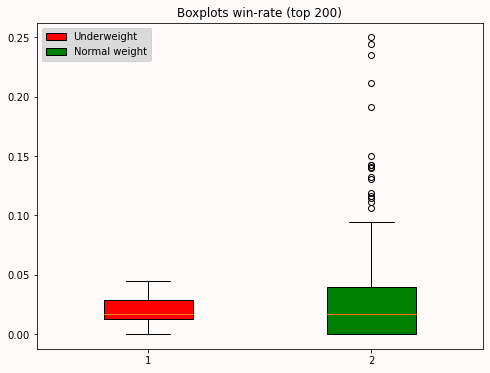

In [24]:
under=top_200[top_200["BMI"]<18.5]
normal=top_200[top_200["BMI"]>18.5]
fig, ax=plt.subplots(figsize=(8,6))
data=[under["win_rate"],normal["win_rate"]]
bp_underweight=ax.boxplot(under["win_rate"],positions=[1],patch_artist=True,boxprops=dict(facecolor="red"),widths=0.4)
bp_normal_weight=ax.boxplot(normal["win_rate"],positions=[2],patch_artist=True,boxprops=dict(facecolor="green"),widths=0.4)
ax.legend([bp_underweight["boxes"][0],bp_normal_weight["boxes"][0]],["Underweight","Normal weight"],loc="upper left",facecolor="lightgray")
ax.set_title("Boxplots win-rate (top 200)")
fig.set_facecolor("snow")
ax.set_facecolor("snow")

I will also take a look at the age of the riders to determine at what age a rider peaks in performance.

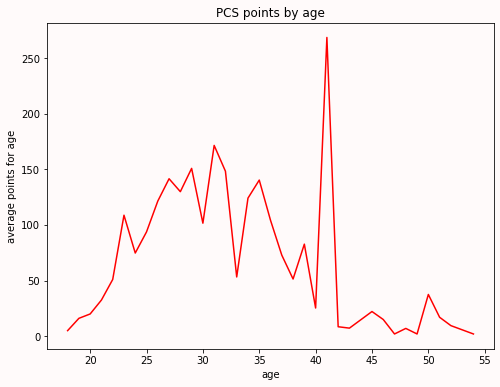

In [25]:
fig, ax= plt.subplots(figsize=(8,6))
ax.plot(PCS[["PCS_points","age"]].groupby("age").mean(),color="red")
ax.set_title("PCS points by age")
ax.set_xlabel("age")
ax.set_ylabel("average points for age")
fig.set_facecolor("snow")
ax.set_facecolor("snow")

Sudden peak at 41 is likely because of a popular rider called Alejandro Valverde, so let's remove him.

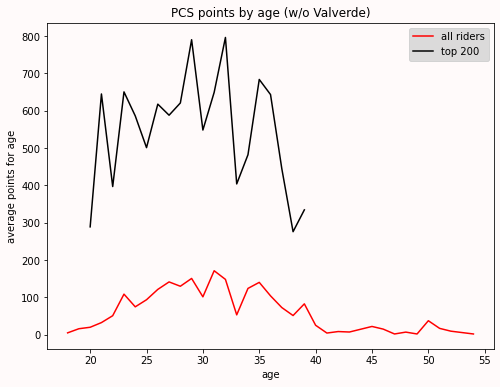

In [26]:
PCS_no_Valverde=PCS[PCS["rider_name"]!="Valverde Alejandro"]
PCS_top200=PCS_no_Valverde[1:200]
fig, ax= plt.subplots(figsize=(8,6))
all_woValverde,=ax.plot(PCS_no_Valverde[["PCS_points","age"]].groupby("age").mean(),color="red")
top200_woValverde,=ax.plot(PCS_top200[["PCS_points","age"]].groupby("age").mean(),color="black")
ax.set_title("PCS points by age (w/o Valverde)")
ax.set_xlabel("age")
ax.set_ylabel("average points for age")
fig.set_facecolor("snow")
ax.set_facecolor("snow")
ax.legend([all_woValverde,top200_woValverde],["all riders","top 200"],loc="upper right",facecolor="lightgray")

We see that riders peak at around 30. The world tour riders almost always quit (or rather are forced to quit) before they hit an age of 40. It gets much harder for them to get a contract. One exception is Alejandro Valverde as discussed above. The sudden peak at an age of 36 may also be explained by Mark Cavendish, who managed to win some Tour De France stages. In general, the career of a world tour rider is maximum 20 years.

### PCS points prediction

First I try to make my regression model manually. I also check for potential log-transformations, but this is the best model I found. This model doesn't use the UCI points because that's not something you would know when trying to predict the PCS points, hence making the model useless. My model has an R-squared of 60.5%.

In [27]:
regression1=smf.ols("PCS_points~weight+year_wins+all_year_GT+years_active+race_km+race_days",PCS).fit()
print(regression1.summary())

                            OLS Regression Results                            
Dep. Variable:             PCS_points   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     334.7
Date:                Fri, 03 Dec 2021   Prob (F-statistic):          1.66e-260
Time:                        07:31:59   Log-Likelihood:                -8651.1
No. Observations:                1321   AIC:                         1.732e+04
Df Residuals:                    1314   BIC:                         1.735e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      211.3958     49.355      4.283   

Now we'll see if we get a similar result using lasso-regression.

In [28]:
PCS_complete=PCS.replace(" ",np.NaN)
PCS_complete=PCS_complete.dropna()
PCS_reg=PCS_complete.drop(["UCI_points","PCS_points","PCS_points_change","one_day_race","TT","GC","Sprint","Climber","rider_name","team","nationality","rank","all_year_wins"],axis=1)
PCS_depend=PCS_complete.PCS_points
x_train,x_test,y_train,y_test=train_test_split(PCS_reg,PCS_depend,test_size=0.2)

In [29]:
PCS_lasso = linear_model.LassoCV(cv=3).fit(x_train,y_train)
PCS_lasso.alpha_
lin_model= linear_model.LinearRegression()
lin_model.fit(x_train, y_train)
lasso_model = linear_model.Lasso(alpha=PCS_lasso.alpha_)
lasso_model.fit(x_train, y_train)
lasso_coefs = pd.Series(dict(zip(list(x_train), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(x_train), lin_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linear=lr_coefs))
coefs

,lasso,linear
rank_change,-0.000000,-0.025290
age,-0.000000,-5.802736
height,-0.000000,-1354.487427
weight,-0.000000,14.329104
year_wins,0.000000,145.615908
all_year_GT,0.000000,7.499365
all_classics,0.000000,1.419086
years_active,0.000000,-0.455920
race_km,0.037722,0.145041
race_days,-0.000000,-20.496483


As we can see see, race_km is the only variable that doesn't get shrunk. This means that if we include race_km in our model, that any other variable leads to overfitting. We have to ask ourselves if it is realistic to include race_km in our model and the answer is yes. Usually the program of a rider gets released before the race season and therefore we can get a good idea of the amount of kilometers a rider will be racing. Besides that, if there is still uncertainty in a rider's program, we can also take the last years kilometers into account since that is not expected to change significantly.

We also have to keep in mind that the riders with a rank higher then 450 have 100 PCS points or below. Our previous model might just make a strong association between low points and low race_km because of those riders. After all, our model will most likely be used to predict scores of the riders with a better rank (world tour riders). Therefore, we now do exactly the same lasso regression for the top-200 ranked riders. 

In [30]:
top_200_complete=top_200.replace(" ",np.NaN)
top_200_complete=top_200_complete.dropna()
top_200_reg=top_200_complete.drop(["UCI_points","PCS_points","PCS_points_change","one_day_race","TT","GC","Sprint","Climber","rider_name","team","nationality","rank","all_year_wins","win_rate"],axis=1)
top_200_depend=top_200_complete.PCS_points
x_train200,x_test200,y_train200,y_test200=train_test_split(top_200_reg,top_200_depend,test_size=0.2)

In [31]:
top_200_lasso = linear_model.LassoCV(cv=3).fit(x_train200,y_train200)
PCS_lasso.alpha_
lin_model200= linear_model.LinearRegression()
lin_model200.fit(x_train200, y_train200)
lasso_model200 = linear_model.Lasso(alpha=top_200_lasso.alpha_)
lasso_model200.fit(x_train200, y_train200)
lasso_coefs200 = pd.Series(dict(zip(list(x_train), lasso_model200.coef_)))
lr_coefs200 = pd.Series(dict(zip(list(x_train200), lin_model200.coef_)))
coefs200 = pd.DataFrame(dict(lasso=lasso_coefs200, linear=lr_coefs200))
coefs200

,lasso,linear
rank_change,-0.000000,-17.915307
age,-0.000000,20.024468
height,0.000000,-7801.240277
weight,-9.211593,96.024016
year_wins,98.901666,108.881321
all_year_GT,2.417687,12.043967
all_classics,5.161332,6.750956
years_active,-2.668829,-38.771036
race_km,0.091323,0.136098
race_days,-13.024342,-21.502815


Now we get more variables in our model and hence it doesn't lead to overfitting as quick as in the previous model. We see that this model is way more in line with our initial model (only all_classics got added). For the sake of completeness we'll have a look at the significance of the lasso-variables in a regular linear regression to see how we ended up with this lasso-regression.

In [32]:
regression2=smf.ols("PCS_points~weight+year_wins+all_year_GT+all_classics+years_active+race_km+race_days",top_200).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:             PCS_points   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     25.97
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           9.52e-25
Time:                        07:32:19   Log-Likelihood:                -1414.5
No. Observations:                 198   AIC:                             2845.
Df Residuals:                     190   BIC:                             2871.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1139.8834    283.754      4.017   

We can clearly see that our lasso-model shrank the least significant variables most. This is by no means a perfect model to predict PCS_points, although it is the best model we can get from our data. We also have to remember that even though the model from the restricted top_200 dataset has a higher functionality, it has only 200 observations, which is rather limited.

## Conclusion

* First of all, we can see that professional cycling is very popular in Europe and especially southern and south-western Europe. This is rather unsurprising since most events also take place in Europe. Nevertheless, it is interesting to see the differences between the different countries.  
* Concerning the ideal "configuration" of a rider, we see that lighter riders generally do better since weight has a negative coefficient in our regression model. However, we should avoid riders that are underweight. They seem to have a lower win-rate. Whether or not this is due to their weight or an omitted variable such as more race days requires more research and additional data. Furthermore, we would prefer riders around the age of 30, since that's when they seem to peak in performance.
* Finally, we see that making a model to predict PCS_score or performance in general is not easy. There is a lot of variation between riders, causing us to overfit the model very fast. If we restrict the model to the best 200 riders, overfitting isn't really an issue anymore. Moreover, our last model (regular linear regression) doesn't even explain half of the variation. This emphasizes that the most important characteristic of a rider is talent. Talent can also be used to make predictions, although you need the right data such as FTP or VO2-max data to do so. World tour teams such as Ineos or Jumbo-Visma spend a lot of time analyzing the training data or race data from their riders and are using that to put together the perfect training schedule, diets etc. By no means is data analytics unimport in the world of cycling.